In [1]:
import pandas as pd
import numpy as np
import warnings
import os
from functools import reduce
warnings.filterwarnings(action='ignore')

import seaborn as sns

sns.set_palette("pastel")
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

sns.set(rc = {'figure.figsize':(15,7)})

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [2]:
def get_season(x):
    season = ''
    if (x == 1) or (x == 2) or (x == 12):
        season = 'winter'
    elif (x == 3) or (x == 4) or (x == 5):
        season = 'spring'
    elif (x == 6) or (x == 7) or (x == 8):
        season = 'summer'
    elif (x == 9) or (x == 10) or (x == 11):
        season = 'fall'
    else:
        season = ''
    return season

**Notation**
- 월별 -> 계절별로 갈수록 대부분 품목에서 상관관계 정도가 강해짐
- 한식과 마트/수퍼마켓의 비율이 카드 사용량과 사용횟수 모두 압도적으로 많지만 한식의 상관관계의 값(절대값)이 두드러져 보이지는 않는다.
- 배달은 어떤 경우에서든지 꾸준히 음의 상관관계 => 제주도 특성 상 관광 지역이 특화되어 있고, 주거 지역의 경우 배달이 많겠지만 아닌 지역의 경우 배달이 없기 때문일 것이다(추측) => 지역의 성격을 재정의 할 필요가 있어보임

In [3]:
waste = pd.read_csv('01_제공데이터/01_음식물쓰레기_FOOD_WASTE.CSV',encoding='cp949')

waste['base_date'] = pd.to_datetime(waste['base_date'])
waste['month'] = waste['base_date'].dt.month
waste['season'] = waste['month'].apply(lambda x: get_season(x)).astype('category')

In [13]:
card = pd.read_csv('01_제공데이터/04_음식관련 카드소비_CARD_SPENDING.CSV',encoding='cp949')

card['base_date'] = pd.to_datetime(card['base_date'])
card['month'] = card['base_date'].dt.month
card['season'] = card['month'].apply(lambda x: get_season(x)).astype('category')

In [14]:
card.head()

,base_date,city,emd_cd,emd_nm,mct_cat_cd,mct_cat_nm,use_cnt,use_amt,month,season
0,2018-01-06,제주시,50110650,연동,C00100,한식,3643,127777300,1,winter
1,2018-01-09,제주시,50110650,연동,C00500,패스트푸드,432,6711675,1,winter
2,2018-01-15,제주시,50110650,연동,C01200,농축수산물,236,16089579,1,winter
3,2018-01-15,제주시,50110650,연동,A00200,마트/슈퍼마켓,4031,121979867,1,winter
4,2018-01-20,제주시,50110650,연동,C01000,식품,633,30410674,1,winter


In [6]:
waste.head()

,base_date,city,emd_cd,emd_nm,em_area_cd,em_cnt,em_g,pay_amt,month,season
0,2018-01-01,제주시,50110670,외도동,W6X062,2,15500,464,1,winter
1,2018-01-01,제주시,50110630,아라동,W6XA97,25,59800,1787,1,winter
2,2018-01-01,제주시,50110630,아라동,W6XA96,8,25350,758,1,winter
3,2018-01-01,제주시,50110630,아라동,W6XA95,12,30000,898,1,winter
4,2018-01-01,제주시,50110630,아라동,W6XA94,14,44050,1317,1,winter


In [7]:
waste.groupby(['base_date'])['em_cnt','em_g','pay_amt'].sum().corr()

,em_cnt,em_g,pay_amt
em_cnt,1.000000,0.891084,0.867387
em_g,0.891084,1.000000,0.970358
pay_amt,0.867387,0.970358,1.000000


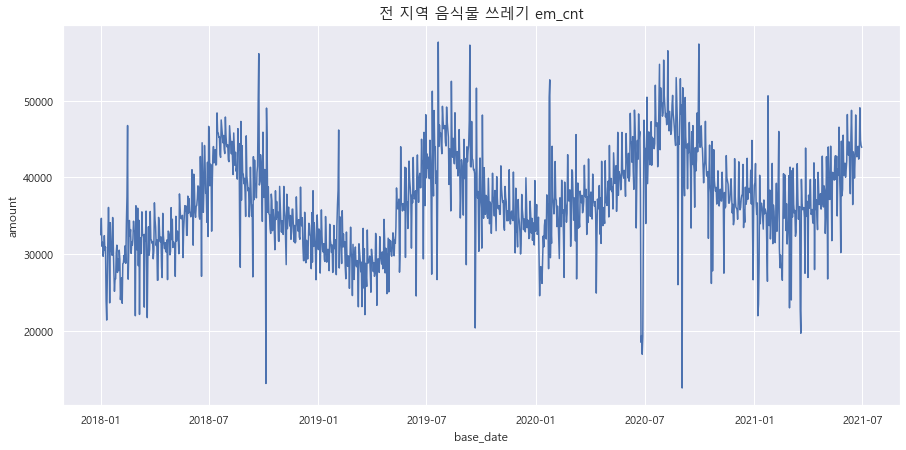

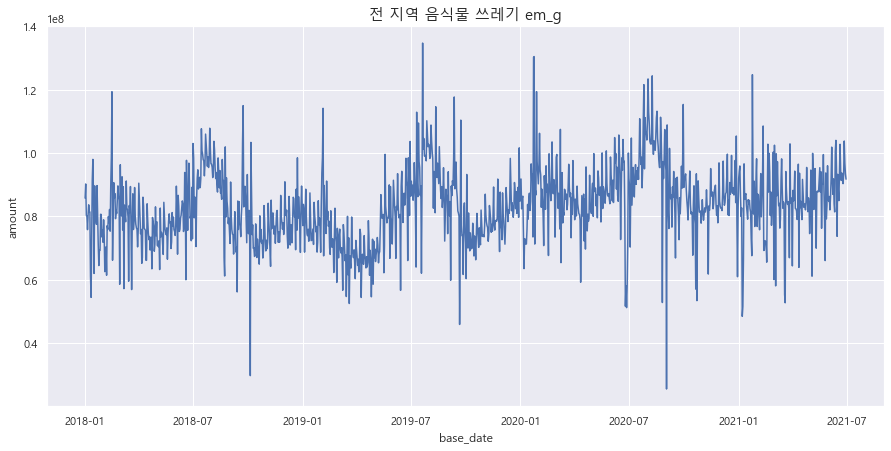

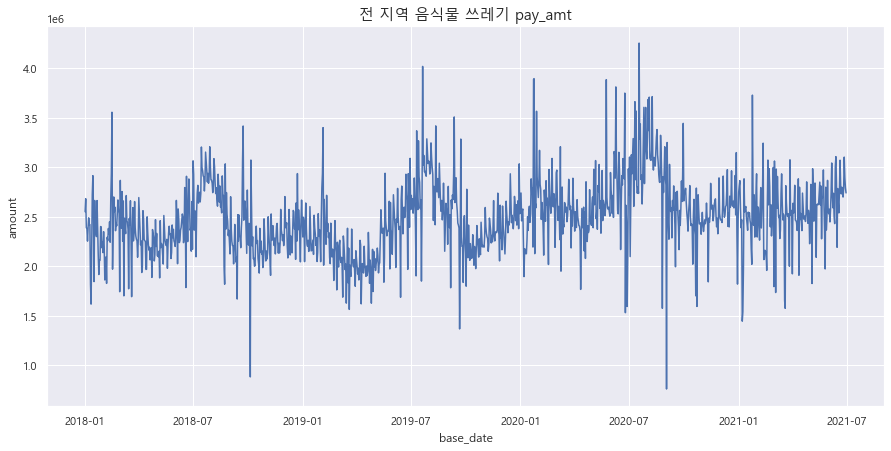

In [8]:
total_waste = waste.groupby(['base_date'])['em_cnt','em_g','pay_amt'].sum().stack().reset_index()
total_waste.columns = ['base_date','em','amount']

for em in total_waste['em'].unique():
    sns.lineplot(data=total_waste[total_waste['em'] == em],x='base_date',y='amount')
    plt.title('전 지역 음식물 쓰레기 {}'.format(em), fontsize=15)
    plt.show()

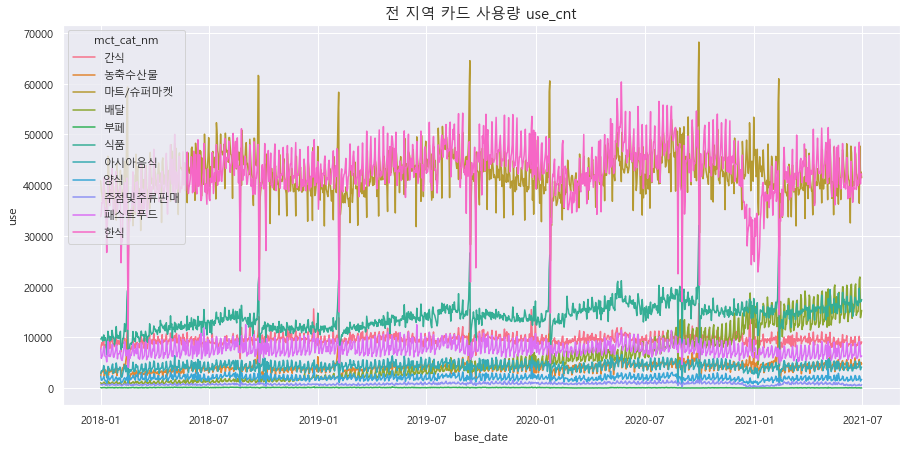

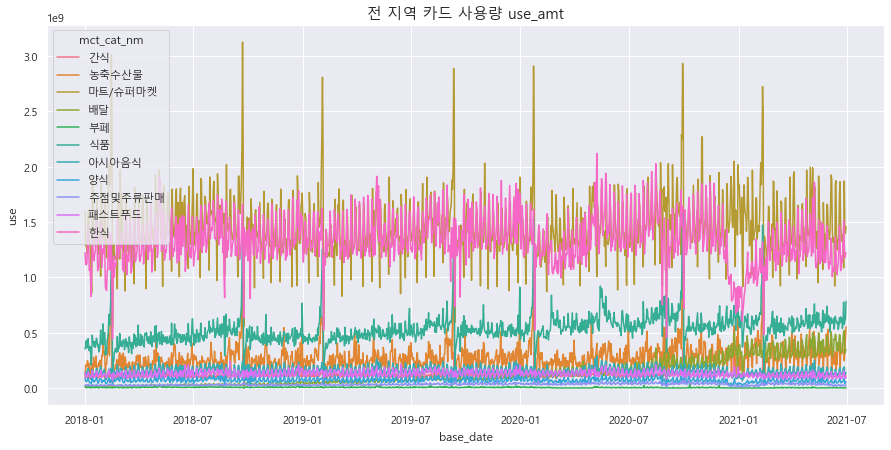

In [16]:
total_card = card.groupby(['base_date','mct_cat_nm'])['use_cnt', 'use_amt'].sum().stack().reset_index()
total_card.columns = ['base_date','mct_cat_nm','card','use']

for c in total_card['card'].unique():
    sns.lineplot(data=total_card[total_card['card'] == c],x='base_date',y='use', hue='mct_cat_nm')
    plt.title('전 지역 카드 사용량 {}'.format(c), fontsize=15)
    plt.show()

# 쓰레기 배출량
상관관계의 절대값으로 순서 선정
- 월별 카드 사용건수 : 마트/슈퍼마켓(0.69) = 패스트푸드(0.69) > 양식(0.6) > 배달(-0.55) = 식품(0.55)
- 계절별 카드 사용건수 : 부페(0.94) > 패스트푸드(0.86) > 마트/슈퍼마켓(0.74) > 농축수산물(0.67) > 식품(0.65) = 양식(0.65) > 아시아음식(0.53)
- 월별 카드 사용금액 : 패스트푸드(0.68) > 양식(0.59) > 배달(-0.57) > 마트/슈퍼마켓(0.54)
- 계절별 카드 사용금액 : 간식(-0.79) > 양식(0.78) > 마트/슈퍼마켓(0.7) > 식품(0.62)

<AxesSubplot:>

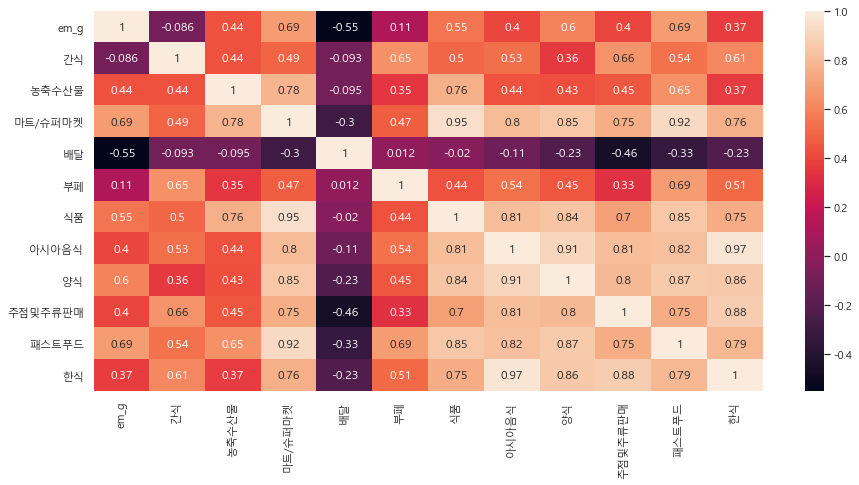

In [30]:
# 쓰레기 배출량과 카드 카테고리별 결제 건수 사이의 월별 상관관계

emg_waste = waste.groupby(['month'])['em_g'].mean().reset_index() # 월평균 쓰레기 배출량
total_mct = card.groupby(['month','mct_cat_nm'])['use_cnt'].mean().reset_index() # 월평균 모든 종류의 유동인구

total_mct = total_mct.pivot_table(index='month',columns = 'mct_cat_nm',values='use_cnt', aggfunc='sum').reset_index()

sns.heatmap(pd.merge(emg_waste, total_mct, on='month',how='left').set_index('month').corr(),annot=True)

<AxesSubplot:>

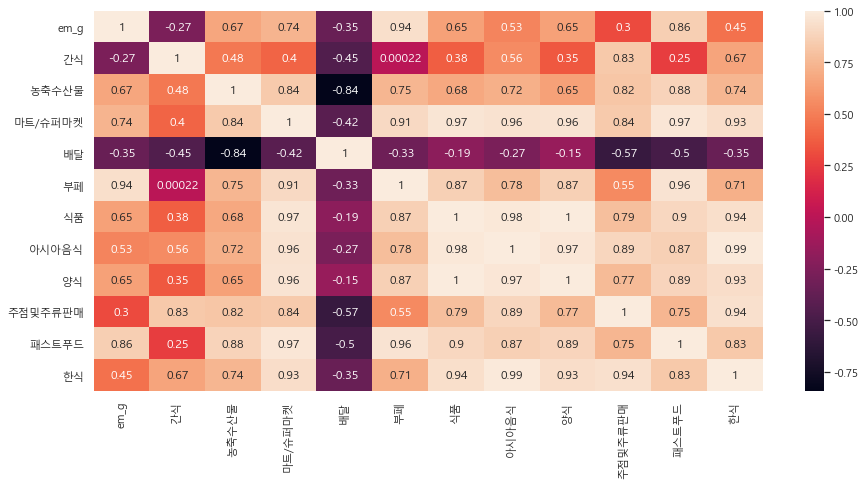

In [34]:
# 쓰레기 배출량과 카드 카테고리별 결제 건수 사이의 계절별 상관관계

emg_waste = waste.groupby(['season'])['em_g'].mean().reset_index() # 월평균 쓰레기 배출량
total_mct = card.groupby(['season','mct_cat_nm'])['use_cnt'].mean().reset_index() # 월평균 모든 종류의 유동인구

total_mct = total_mct.pivot_table(index='season',columns = 'mct_cat_nm',values='use_cnt', aggfunc='sum').reset_index()

sns.heatmap(pd.merge(emg_waste, total_mct, on='season',how='left').set_index('season').corr(),annot=True)

<AxesSubplot:>

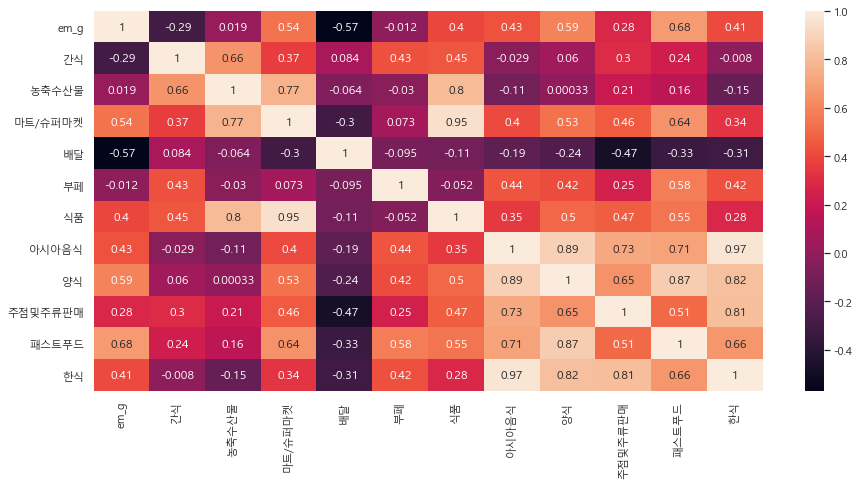

In [33]:
# 쓰레기 배출량과 카드 카테고리별 결제 금액 사이의 월별 상관관계

emg_waste = waste.groupby(['month'])['em_g'].mean().reset_index() # 월평균 쓰레기 배출량
total_mct = card.groupby(['month','mct_cat_nm'])['use_amt'].mean().reset_index() # 월평균 모든 종류의 유동인구

total_mct = total_mct.pivot_table(index='month',columns = 'mct_cat_nm',values='use_amt', aggfunc='sum').reset_index()

sns.heatmap(pd.merge(emg_waste, total_mct, on='month',how='left').set_index('month').corr(),annot=True)

<AxesSubplot:>

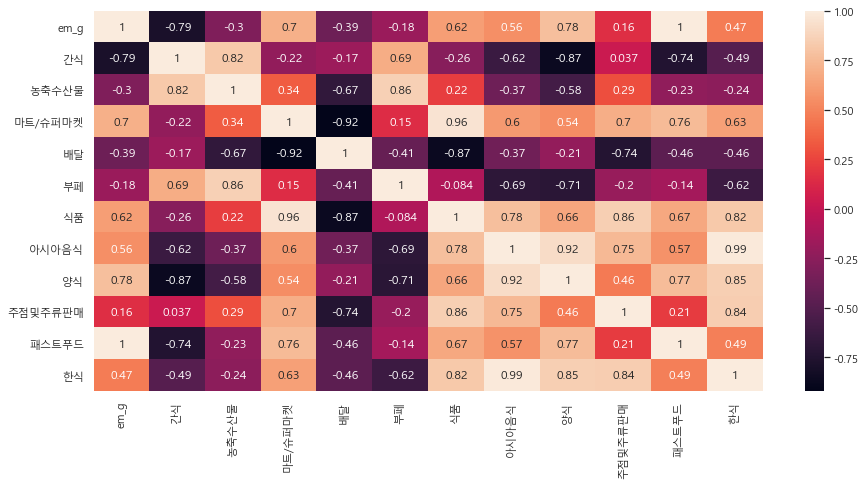

In [35]:
# 쓰레기 배출량과 카드 카테고리별 결제 금액 사이의 계절별 상관관계

emg_waste = waste.groupby(['season'])['em_g'].mean().reset_index() # 월평균 쓰레기 배출량
total_mct = card.groupby(['season','mct_cat_nm'])['use_amt'].mean().reset_index() # 월평균 모든 종류의 유동인구

total_mct = total_mct.pivot_table(index='season',columns = 'mct_cat_nm',values='use_amt', aggfunc='sum').reset_index()

sns.heatmap(pd.merge(emg_waste, total_mct, on='season',how='left').set_index('season').corr(),annot=True)

# 쓰레기 배출건수
상관관계의 절대값으로 순서 선정
- 월별 카드 사용건수 : 마트/슈퍼마켓(0.91) = 패스트푸드(0.84) > 양식(0.8) > 식품(0.79) > 주점및주류판매(0.75) > 아시아음식(0.71) > 한식(0.69) = 농축수산물(0.66) > 배달(-0.54)
- 계절별 카드 사용건수 : 패스트푸드(0.99) > 마트/슈퍼마켓(0.97) > 농축수산물(0.93) > 부페(0.92) > 식품(0.88) > 아시아음식(0.86) = 양식(0.86) > 한식(0.85) > 주점및주류판매(0.8) > 배달(-0.6)
- 월별 카드 사용금액 : 마트/수퍼마켓(0.68) = 양식(0.68) > 아시아음식(0.67) = 한식(0.67) > 패스트푸드(0.65) > 주점및주류판매(0.64) > 배달(-0.59) > 식품(0.57)
- 계절별 카드 사용금액 : 식품(0.94) > 마트/수퍼마켓(0.9) > 아시아음식(0.86) > 한식(0.85) = 양식(0.85) > 패스트푸드(0.84) > 주점및주류판매(0.7) > 배달(-0.69) > 간식(-0.57)

<AxesSubplot:>

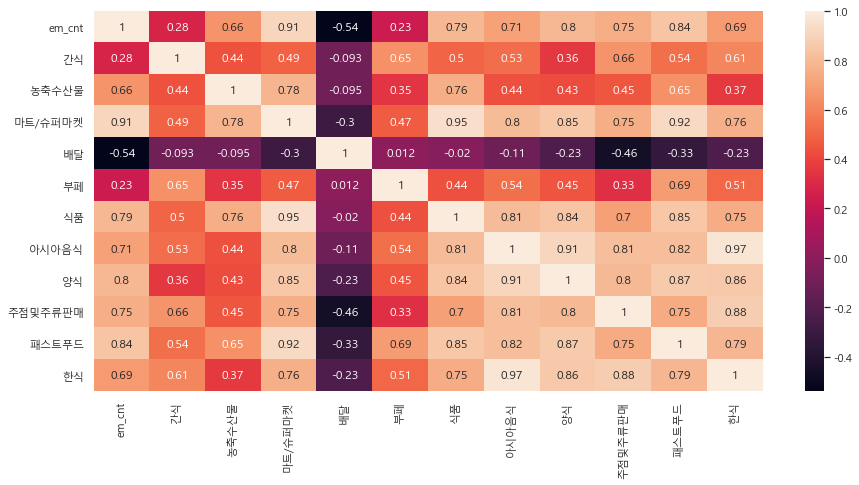

In [36]:
# 쓰레기 배출건수와 카드 카테고리별 결제 건수 사이의 월별 상관관계

emg_waste = waste.groupby(['month'])['em_cnt'].mean().reset_index() # 월평균 쓰레기 배출량
total_mct = card.groupby(['month','mct_cat_nm'])['use_cnt'].mean().reset_index() # 월평균 모든 종류의 유동인구

total_mct = total_mct.pivot_table(index='month',columns = 'mct_cat_nm',values='use_cnt', aggfunc='sum').reset_index()

sns.heatmap(pd.merge(emg_waste, total_mct, on='month',how='left').set_index('month').corr(),annot=True)

<AxesSubplot:>

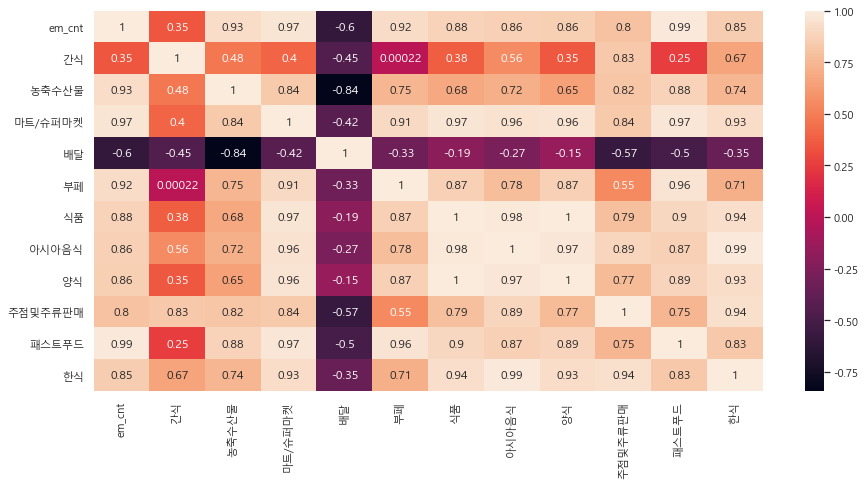

In [38]:
# 쓰레기 배출건수와 카드 카테고리별 결제 건수 사이의 계절별 상관관계

emg_waste = waste.groupby(['season'])['em_cnt'].mean().reset_index() # 월평균 쓰레기 배출량
total_mct = card.groupby(['season','mct_cat_nm'])['use_cnt'].mean().reset_index() # 월평균 모든 종류의 유동인구

total_mct = total_mct.pivot_table(index='season',columns = 'mct_cat_nm',values='use_cnt', aggfunc='sum').reset_index()

sns.heatmap(pd.merge(emg_waste, total_mct, on='season',how='left').set_index('season').corr(),annot=True)

<AxesSubplot:>

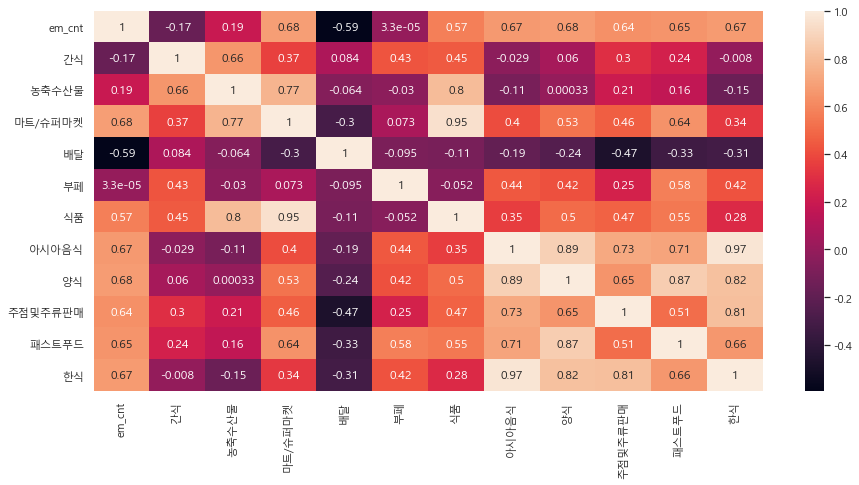

In [37]:
# 쓰레기 배출건수와 카드 카테고리별 결제 금액 사이의 월별 상관관계

emg_waste = waste.groupby(['month'])['em_cnt'].mean().reset_index() # 월평균 쓰레기 배출량
total_mct = card.groupby(['month','mct_cat_nm'])['use_amt'].mean().reset_index() # 월평균 모든 종류의 유동인구

total_mct = total_mct.pivot_table(index='month',columns = 'mct_cat_nm',values='use_amt', aggfunc='sum').reset_index()

sns.heatmap(pd.merge(emg_waste, total_mct, on='month',how='left').set_index('month').corr(),annot=True)

<AxesSubplot:>

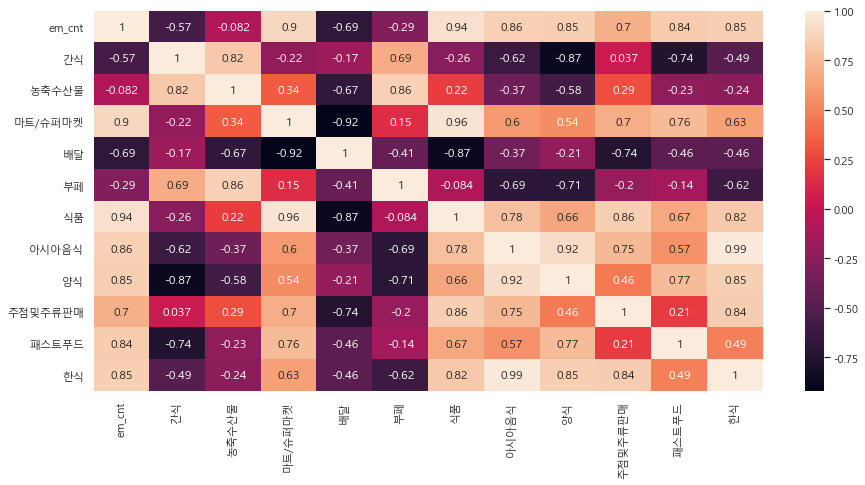

In [39]:
# 쓰레기 배출건수와 카드 카테고리별 결제 금액 사이의 계절별 상관관계

emg_waste = waste.groupby(['season'])['em_cnt'].mean().reset_index() # 월평균 쓰레기 배출량
total_mct = card.groupby(['season','mct_cat_nm'])['use_amt'].mean().reset_index() # 월평균 모든 종류의 유동인구

total_mct = total_mct.pivot_table(index='season',columns = 'mct_cat_nm',values='use_amt', aggfunc='sum').reset_index()

sns.heatmap(pd.merge(emg_waste, total_mct, on='season',how='left').set_index('season').corr(),annot=True)